# 🗳️ Predictor de Voto Electoral
**Machine Learning aplicado a datos del CIS**

**Fecha:** Enero 2026
**Autor:** Rubén Díaz Grano de Oro  

## 🎯 Objetivo del Proyecto

**Predecir intención de voto entre los 4 partidos mayoritarios** mediante Machine Learning utilizando variables sociodemográficas de encuestas del CIS.

### 📊 Fuente de Datos: Barómetros CIS 2025

**¿Qué son los barómetros del CIS?**
- Encuestas mensuales con ~4.000 entrevistas presenciales en hogares
- Muestreo estratificado por CCAA, tamaño de municipio, sexo y edad
- Microdatos públicos y gratuitos (disponibles en formato SPSS)

**Ventajas de usar datos del CIS:**
- ✅ **Gran volumen de datos:** ~4.000 entrevistas/mes (vs. 1.000-2.000 de encuestadoras privadas)
- ✅ **Total anual:** ~44.000 casos (11 barómetros de 2025, agosto no tiene barómetro)
- ✅ **Microdatos públicos:** Accesibles gratuitamente para investigación
- ✅ **Submuestras representativas:** Por comunidad autónoma, sexo, edad, tamaño de municipio
- ✅ **Metodología rigurosa:** Entrevistas telefónicas con cuestionario estandarizado

**Limitaciones conocidas:**
- ⚠️ **Sesgo histórico:** El CIS tiende a sobrestimar el voto al PSOE en sus estimaciones
- ⚠️ **Partidos minoritarios:** Pocas muestras de partidos pequeños, especialmente de los nacionalistas/independentistas
- ⚠️ **Momento político:** Refleja la situación de 2025, no es generalizable a otros períodos
- ⚠️ **Efecto declaración:** Los encuestados pueden no revelar su verdadera intención de voto

**Datos utilizados en este proyecto:**
- **11 barómetros de 2025:** Enero, febrero, marzo, abril, mayo, junio, julio, septiembre, octubre, noviembre, diciembre
- **Total de registros:** ~44.000 entrevistas
- **Período temporal:** Enero-diciembre 2025 (sin agosto)

## 📂 2. Carga y Preparación de Datos

**Fuente:** Barómetros CIS 2025 (11 meses - excepto agosto)  
**Formato:** SPSS (.sav) → DataFrame de Pandas  
**Total esperado:** ~44.000 registros

In [74]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### 📥 Carga de archivos SPSS

In [75]:
import pyreadstat

# Cargar todos los barómetros de 2025 (11 meses - agosto no tiene barómetro)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 
         'septiembre', 'octubre', 'noviembre', 'diciembre']
archivos = [f'data/{mes}.sav' for mes in meses]
dataframes = []

for archivo in archivos:
    df_temp, meta = pyreadstat.read_sav(archivo)
    print(f"Cargado {archivo}: {df_temp.shape[0]} filas")
    dataframes.append(df_temp)

# Combinar todos los dataframes
df = pd.concat(dataframes, ignore_index=True)

print(f"\n✅ Total combinado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"📅 Barómetros cargados: {len(meses)} meses de 2025")
print(f"\nPrimeras filas del dataset combinado:")
print(df.head())

Cargado data/enero.sav: 4024 filas
Cargado data/febrero.sav: 4042 filas
Cargado data/marzo.sav: 4018 filas
Cargado data/abril.sav: 4008 filas
Cargado data/mayo.sav: 4018 filas
Cargado data/junio.sav: 4013 filas
Cargado data/julio.sav: 4018 filas
Cargado data/septiembre.sav: 4122 filas
Cargado data/octubre.sav: 4029 filas
Cargado data/noviembre.sav: 4027 filas
Cargado data/diciembre.sav: 4017 filas

✅ Total combinado: 44336 filas, 315 columnas
📅 Barómetros cargados: 11 meses de 2025

Primeras filas del dataset combinado:
   ESTUDIO  ENTREV  REGISTRO    CUES  TIPO_TEL  CCAA  PROV   MUN  TAMUNI  \
0   3492.0     0.0   42757.0  1563.0       2.0   1.0   4.0   0.0     1.0   
1   3492.0     0.0   63963.0  2253.0       2.0   1.0   4.0   0.0     2.0   
2   3492.0     0.0   24070.0   883.0       2.0   1.0   4.0  13.0     5.0   
3   3492.0     0.0   41616.0  1520.0       2.0   1.0   4.0  13.0     5.0   
4   3492.0     0.0   42259.0  1544.0       2.0   1.0   4.0  13.0     5.0   

   CAPITAL  SEXO 

## 📊 3. Variables Seleccionadas

### Variables Predictoras (Features) - 8 variables sociodemográficas

1. 🗺️ **CCAA** - Comunidad Autónoma de residencia (18 categorías)
   - 17 CCAA + Ceuta y Melilla agrupadas

2. 👥 **SEXO** - Género (2 categorías)
   - Hombre / Mujer

3. 📅 **GRUPO_EDAD** - Grupos de edad (6 categorías)
   - 18-29, 30-39, 40-49, 50-59, 60-69, 70+
   - Agrupación propia para facilitar interpretación

4. 💭 **ESCIDEOL** - Escala ideológica 1-10 (variable numérica)
   - 1 = Izquierda extrema
   - 10 = Derecha extrema
   - 4-5 = Centro político

5. 🏙️ **TAMUNI** - Tamaño del municipio de residencia (3 categorías)
   - 0-10.000 habitantes (rural/pequeño)
   - 10.001-100.000 habitantes (mediano)
   - Más de 100.000 habitantes (urbano/grande)

6. ☑️ **PARTICIPACIONG** - Participación en las últimas Elecciones Generales (2 categorías)
   - Sí votó / No votó

7. 🎓 **ESTUDIOS** - Nivel educativo alcanzado (4 categorías)
   - Sin estudios o primaria
   - Secundaria (ESO, Bachillerato)
   - Formación Profesional
   - Estudios superiores (Universidad)

8. 💼 **SITLAB** - Situación laboral actual (4 categorías)
   - Trabaja
   - En paro
   - Pensionista (jubilado, incapacidad)
   - Otra situación (estudiante, trabajo doméstico)

---

### Variable Objetivo (Target)

🎯 **VOTOSIMG** - Voto declarado en las últimas Elecciones Generales 2023

**Partidos incluidos en el modelo (4 mayoritarios):**
- **PSOE** (Partido Socialista Obrero Español) 
- **PP** (Partido Popular)
- **VOX**
- **Sumar**

**Criterio de selección:** Solo partidos con más de 3.000 casos en el dataset para garantizar entrenamiento robusto y predicciones fiables.

**Partidos excluidos del modelo:**
- Partidos nacionalistas: ERC, Junts, PNV, Bildu, Coalición Canaria
- Otros partidos minoritarios: Podemos, SALF
- Votos en blanco, nulos y abstenciones

**Total de casos válidos tras filtrado:** ~40.000 registros con datos completos de los 4 partidos principales.

In [76]:
# Seleccionar columnas de interés
columnas_interes = [
    'CCAA', 'SEXO', 'EDAD', 'VOTOSIMG', 
    'ESCIDEOL', 'TAMUNI', 'PARTICIPACIONG', 
    'ESTUDIOS', 'SITLAB'
]

# Crear dataframe filtrado
df_filtrado = df[columnas_interes].copy()

print(f"✅ Dataset filtrado: {df_filtrado.shape}")
print(f"📊 Variables seleccionadas: {len(columnas_interes)}")
print(f"\nPrimeras filas:")
print(df_filtrado.head())

✅ Dataset filtrado: (44336, 9)
📊 Variables seleccionadas: 9

Primeras filas:
   CCAA  SEXO  EDAD  VOTOSIMG  ESCIDEOL  TAMUNI  PARTICIPACIONG  ESTUDIOS  \
0   1.0   1.0  53.0    9977.0       5.0     1.0             1.0       1.0   
1   1.0   1.0  32.0       2.0       4.0     2.0             1.0       4.0   
2   1.0   2.0  66.0       1.0       4.0     5.0             1.0       6.0   
3   1.0   1.0  53.0    9998.0       1.0     5.0             1.0       4.0   
4   1.0   1.0  31.0       1.0      10.0     5.0             1.0       6.0   

   SITLAB  
0     2.0  
1     4.0  
2     2.0  
3     4.0  
4     1.0  


## 🧹 4. Limpieza y Recodificación de Variables

**Proceso:**
1. ✅ Convertir códigos numéricos a etiquetas descriptivas
2. ✅ Agrupar categorías similares
3. ✅ Gestionar valores nulos (98, 99, 8996, 9997, 9998, 9999)
4. ✅ Simplificar partidos minoritarios a "Otro partido"

**Metodología:** Recodificación basada en el codebook oficial del CIS

In [77]:
# CCAA
ccaa_mapping = {
    1: 'Andalucía',
    2: 'Aragón',
    3: 'Asturias',
    4: 'Balears',
    5: 'Canarias',
    6: 'Cantabria',
    7: 'Castilla-La Mancha',
    8: 'Castilla y León',
    9: 'Catalunya',
    10: 'Comunitat Valenciana',
    11: 'Extremadura',
    12: 'Galicia',
    13: 'Madrid',
    14: 'Murcia',
    15: 'Navarra',
    16: 'Euskadi',
    17: 'La Rioja',
    18: 'Ceuta y Melilla',
    19: 'Ceuta y Melilla'
}

df_filtrado.loc[:, 'CCAA'] = df_filtrado['CCAA'].map(ccaa_mapping)
print(df_filtrado['CCAA'].value_counts())

CCAA
Andalucía               7630
Madrid                  6187
Catalunya               6184
Comunitat Valenciana    4368
Galicia                 2646
Castilla y León         2245
Euskadi                 1981
Castilla-La Mancha      1849
Canarias                1810
Murcia                  1325
Balears                 1151
Aragón                  1133
Extremadura             1132
Navarra                 1110
Cantabria               1108
Asturias                1062
La Rioja                1025
Ceuta y Melilla          390
Name: count, dtype: int64


In [78]:
# SEXO - Convertir a Hombre y Mujer
sexo_mapping = {
    1: 'Hombre',
    2: 'Mujer'
}

df_filtrado.loc[:, 'SEXO'] = df_filtrado['SEXO'].map(sexo_mapping)
print(df_filtrado['SEXO'].value_counts())

SEXO
Hombre    23077
Mujer     21259
Name: count, dtype: int64


In [79]:
# Recodificación de ESCIDEOL (Escala ideológica 1-10)
# Convertir valores 0, 98 y 99 a NA
escideol_mapping = {i: i for i in range(1, 11)}  # 1-10 son valores válidos
escideol_mapping[0] = np.nan  # 0 no es un valor válido en CIS
escideol_mapping[98] = np.nan
escideol_mapping[99] = np.nan

df_filtrado.loc[:, 'ESCIDEOL'] = df_filtrado['ESCIDEOL'].map(escideol_mapping)
print("✅ ESCIDEOL recodificado")
print(df_filtrado['ESCIDEOL'].value_counts(dropna=False).sort_index())

✅ ESCIDEOL recodificado
ESCIDEOL
1.0     5228
2.0     3104
3.0     6347
4.0     4506
5.0     9856
6.0     4098
7.0     3699
8.0     2687
9.0      698
10.0    2449
NaN     1664
Name: count, dtype: int64


In [80]:
# Crear grupos de edad
def crear_grupo_edad(edad):
    if edad < 29:
        return '18-29'
    elif edad < 39:
        return '30-39'
    elif edad < 49:
        return '40-49'
    elif edad < 59:
        return '50-59'
    elif edad < 69:
        return '60-69'
    else:
        return '70+'

df_filtrado['GRUPO_EDAD'] = df_filtrado['EDAD'].apply(crear_grupo_edad)
print("✅ Grupos de edad creados")
print(df_filtrado['GRUPO_EDAD'].value_counts().sort_index())

✅ Grupos de edad creados
GRUPO_EDAD
18-29     4630
30-39     6073
40-49     8485
50-59    10129
60-69     8149
70+       6870
Name: count, dtype: int64


In [81]:
# ========================================
# RECODIFICACIÓN DE VOTOSIMG (Variable Objetivo)
# ========================================
# Convertimos los códigos numéricos del CIS a nombres de partidos
# y marcamos como NA los valores que representan no-voto o respuestas inválidas

votosimg_recoded = {
    # Partidos principales (códigos del CIS)
    1: 'PSOE',
    2: 'PP',
    3: 'VOX',
    21: 'Sumar',
    # Valores no válidos → marcamos como NaN
    8996: np.nan,  # No tenía edad para votar
    9977: np.nan,  # Voto en blanco
    9997: np.nan,  # No votó (abstención)
    9998: np.nan,  # No recuerda
    9999: np.nan   # No contesta
}

# Aplicar recodificación
# IMPORTANTE: Todos los códigos de partidos minoritarios que no están en el diccionario
# se convierten automáticamente en NaN (serán eliminados después)
df_filtrado['VOTOSIMG'] = df_filtrado['VOTOSIMG'].map(votosimg_recoded)

print("✅ VOTOSIMG recodificado a nombres de partidos")
print(f"\n📊 Distribución de votos:")
print(df_filtrado['VOTOSIMG'].value_counts(dropna=False))
print(f"\n⚠️ Valores NaN (serán eliminados): {df_filtrado['VOTOSIMG'].isna().sum():,}")

✅ VOTOSIMG recodificado a nombres de partidos

📊 Distribución de votos:
VOTOSIMG
NaN      15818
PSOE     11329
PP        9620
VOX       4426
Sumar     3143
Name: count, dtype: int64

⚠️ Valores NaN (serán eliminados): 15,818


In [82]:
# Recodificación de TAMUNI
tamuni_mapping = {
    1: '0-10.000',
    2: '0-10.000',
    3: '10.001-100.000',
    4: '10.001-100.000',
    5: '>100.000',
    6: '>100.000',
    7: '>100.000'
}

df_filtrado.loc[:, 'TAMUNI'] = df_filtrado['TAMUNI'].map(tamuni_mapping)
print(df_filtrado['TAMUNI'].value_counts())

TAMUNI
>100.000          19819
10.001-100.000    17064
0-10.000           7453
Name: count, dtype: int64


In [84]:
# Recodificación de PARTICIPACIONG
participacion_mapping = {
    1: 'Sí',
    2: 'No',
    3: 'No',
    4: 'No',
    8: np.nan,
    9: np.nan
}

df_filtrado.loc[:, 'PARTICIPACIONG'] = df_filtrado['PARTICIPACIONG'].map(participacion_mapping)
print(df_filtrado['PARTICIPACIONG'].value_counts())

PARTICIPACIONG
Sí    38366
No     5777
Name: count, dtype: int64


In [85]:
#SITLAB
sitlab_mapping = {
    1: 'Trabaja',
    2: 'Pensionista',
    3: 'Pensionista',
    4: 'En paro',
    5: 'En paro',
    6: 'Otra situación',
    7: 'Otra situación',
    8: 'Otra situación',
    9: np.nan
}

df_filtrado.loc[:, 'SITLAB'] = df_filtrado['SITLAB'].map(sitlab_mapping)
print(df_filtrado['SITLAB'].value_counts())

SITLAB
Trabaja           27152
Pensionista       10222
En paro            3596
Otra situación     3328
Name: count, dtype: int64


In [86]:
# ESTUDIOS
estudios_mapping = {
    1: 'Sin estudios o primaria',
    2: 'Sin estudios o primaria',
    3: 'Secundaria',
    4: 'Secundaria',
    5: 'Formación Profesional',
    6: 'Superiores',
    7: np.nan,
    9: np.nan
}
df_filtrado.loc[:, 'ESTUDIOS'] = df_filtrado['ESTUDIOS'].map(estudios_mapping)
print(df_filtrado['ESTUDIOS'].value_counts())

ESTUDIOS
Superiores                 22975
Secundaria                 10693
Formación Profesional       8953
Sin estudios o primaria     1641
Name: count, dtype: int64


In [107]:
# Verificar el resultado de la recodificación
print("✅ Recodificación completada")
print(f"\nResumen del dataset:")
print(f"- Total de registros: {len(df_filtrado)}")
print(f"- Variables: {df_filtrado.shape[1]}")
print(f"\nDistribución de partidos:")
print(df_filtrado['VOTOSIMG'].value_counts())
print(f"\nValores nulos por variable:")
print(df_filtrado.isnull().sum())

✅ Recodificación completada

Resumen del dataset:
- Total de registros: 44336
- Variables: 10

Distribución de partidos:
VOTOSIMG
PSOE     11329
PP        9620
VOX       4426
Sumar     3143
Name: count, dtype: int64

Valores nulos por variable:
CCAA                  0
SEXO                  0
EDAD                  0
VOTOSIMG          15818
ESCIDEOL           1664
TAMUNI                0
PARTICIPACIONG      193
ESTUDIOS             74
SITLAB               38
GRUPO_EDAD            0
dtype: int64


## 🔧 5. Preparación para Machine Learning

**Objetivo:** Transformar los datos limpios en un formato adecuado para entrenamiento de modelos.

**Pasos aplicados:**
1. 🎯 **Filtrar solo votos válidos:** Eliminar blancos, nulos, abstenciones y partidos minoritarios
2. 🧹 **Eliminar valores faltantes (NaN)** en variables predictoras
3. 🔢 **One-Hot Encoding:** Convertir variables categóricas en variables binarias (dummies)
4. 💾 **Exportar dataset limpio** para respaldo y análisis posterior

**Partidos incluidos en el modelo:** 
- PSOE (izquierda)
- PP (centro-derecha)
- VOX (derecha)
- Sumar (izquierda)

**Total:** 4 partidos principales con suficientes casos para entrenar el modelo de forma robusta.

In [87]:
# ========================================
# PASO 1: FILTRAR VOTOS VÁLIDOS
# ========================================
# Nos quedamos SOLO con los 4 partidos principales que tienen suficientes casos
# Esto elimina: abstenciones, votos en blanco, partidos minoritarios, y respuestas inválidas

print(f"📋 Registros antes del filtrado: {len(df_filtrado):,}")
print("\n📊 Distribución original de VOTOSIMG:")
print(df_filtrado['VOTOSIMG'].value_counts(dropna=False))

# Definir los 4 partidos que incluiremos en el modelo
partidos_validos = ['PSOE', 'PP', 'VOX', 'Sumar']

# Filtrar el dataframe
df_ml = df_filtrado[df_filtrado['VOTOSIMG'].isin(partidos_validos)].copy()

print(f"\n✅ Registros después del filtrado: {len(df_ml):,}")
print(f"❌ Registros eliminados: {len(df_filtrado) - len(df_ml):,}")
print(f"\n📊 Distribución final (solo partidos válidos):")
print(df_ml['VOTOSIMG'].value_counts())

📋 Registros antes del filtrado: 44,336

📊 Distribución original de VOTOSIMG:
VOTOSIMG
NaN      15818
PSOE     11329
PP        9620
VOX       4426
Sumar     3143
Name: count, dtype: int64

✅ Registros después del filtrado: 28,518
❌ Registros eliminados: 15,818

📊 Distribución final (solo partidos válidos):
VOTOSIMG
PSOE     11329
PP        9620
VOX       4426
Sumar     3143
Name: count, dtype: int64


In [88]:
# ========================================
# PASO 2: ELIMINAR VALORES FALTANTES (NaN)
# ========================================
# Eliminamos filas donde falten datos en las variables predictoras
# Esto asegura que el modelo tenga información completa para cada caso

print(f"📋 Valores nulos por columna ANTES de limpiar:")
print(df_ml.isnull().sum())
print(f"\n⚠️ Total de filas con algún valor nulo: {df_ml.isnull().any(axis=1).sum():,}")

# Eliminar filas con cualquier valor nulo
df_ml = df_ml.dropna()

print(f"\n✅ Registros después de eliminar nulos: {len(df_ml):,}")
print(f"\n📊 Distribución final de la variable objetivo:")
print(df_ml['VOTOSIMG'].value_counts())
print(f"\n💡 Dataset listo con {len(df_ml):,} casos completos para entrenar el modelo")

📋 Valores nulos por columna ANTES de limpiar:
CCAA                0
SEXO                0
EDAD                0
VOTOSIMG            0
ESCIDEOL          452
TAMUNI              0
PARTICIPACIONG     66
ESTUDIOS           39
SITLAB             15
GRUPO_EDAD          0
dtype: int64

⚠️ Total de filas con algún valor nulo: 559

✅ Registros después de eliminar nulos: 27,959

📊 Distribución final de la variable objetivo:
VOTOSIMG
PSOE     11142
PP        9449
VOX       4241
Sumar     3127
Name: count, dtype: int64

💡 Dataset listo con 27,959 casos completos para entrenar el modelo


In [89]:
# ========================================
# PASO 3: ONE-HOT ENCODING DE VARIABLES CATEGÓRICAS
# ========================================
# Convertimos variables categóricas (texto) en variables numéricas binarias (0/1)
# Ejemplo: SEXO → SEXO_Mujer (1 si es mujer, 0 si es hombre)

# Separar la variable objetivo (y) de las variables predictoras (X)
y = df_ml['VOTOSIMG']

# Preparar las variables predictoras
# IMPORTANTE: Eliminamos EDAD (continua) porque ya tenemos GRUPO_EDAD (categórica)
X = df_ml.drop(['VOTOSIMG', 'EDAD'], axis=1)

# Aplicar One-Hot Encoding
# drop_first=True: Elimina la primera categoría de cada variable para evitar multicolinealidad
# Ejemplo: Si SEXO tiene [Hombre, Mujer], solo crea la columna SEXO_Mujer
#          Si es 1 → Mujer, Si es 0 → Hombre (implícito)
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"✅ One-Hot Encoding aplicado correctamente")
print(f"\n📊 Resumen de variables:")
print(f"   • Variables originales: {X.shape[1]}")
print(f"   • Variables después de encoding: {X_encoded.shape[1]}")
print(f"   • Registros totales: {X_encoded.shape[0]:,}")
print(f"\n📋 Columnas generadas:")
for col in sorted(X_encoded.columns):
    print(f"   - {col}")

✅ One-Hot Encoding aplicado correctamente

📊 Resumen de variables:
   • Variables originales: 8
   • Variables después de encoding: 33
   • Registros totales: 27,959

📋 Columnas generadas:
   - CCAA_Aragón
   - CCAA_Asturias
   - CCAA_Balears
   - CCAA_Canarias
   - CCAA_Cantabria
   - CCAA_Castilla y León
   - CCAA_Castilla-La Mancha
   - CCAA_Catalunya
   - CCAA_Ceuta y Melilla
   - CCAA_Comunitat Valenciana
   - CCAA_Euskadi
   - CCAA_Extremadura
   - CCAA_Galicia
   - CCAA_La Rioja
   - CCAA_Madrid
   - CCAA_Murcia
   - CCAA_Navarra
   - ESCIDEOL
   - ESTUDIOS_Secundaria
   - ESTUDIOS_Sin estudios o primaria
   - ESTUDIOS_Superiores
   - GRUPO_EDAD_30-39
   - GRUPO_EDAD_40-49
   - GRUPO_EDAD_50-59
   - GRUPO_EDAD_60-69
   - GRUPO_EDAD_70+
   - PARTICIPACIONG_Sí
   - SEXO_Mujer
   - SITLAB_Otra situación
   - SITLAB_Pensionista
   - SITLAB_Trabaja
   - TAMUNI_10.001-100.000
   - TAMUNI_>100.000


In [90]:
# ========================================
# PASO 4: CREAR DATASET FINAL PARA ML
# ========================================
# Combinamos las variables predictoras (X) con la variable objetivo (y)
# en un único DataFrame listo para PyCaret

df_final = X_encoded.copy()
df_final['VOTO'] = y.values

print(f"✅ Dataset final creado")
print(f"\n📊 Dimensiones finales:")
print(f"   • Filas (casos): {df_final.shape[0]:,}")
print(f"   • Columnas (variables + target): {df_final.shape[1]}")
print(f"\n📋 Primeras filas del dataset:")
print(df_final.head(3))
print(f"\n🎯 Distribución de la variable objetivo (VOTO):")
print(df_final['VOTO'].value_counts())
print(f"\n💡 El dataset está balanceado entre clases:")
for partido, count in df_final['VOTO'].value_counts().items():
    porcentaje = (count / len(df_final)) * 100
    print(f"   - {partido}: {count:,} casos ({porcentaje:.1f}%)")

✅ Dataset final creado

📊 Dimensiones finales:
   • Filas (casos): 27,959
   • Columnas (variables + target): 34

📋 Primeras filas del dataset:
   ESCIDEOL  CCAA_Aragón  CCAA_Asturias  CCAA_Balears  CCAA_Canarias  \
1       4.0        False          False         False          False   
2       4.0        False          False         False          False   
4      10.0        False          False         False          False   

   CCAA_Cantabria  CCAA_Castilla y León  CCAA_Castilla-La Mancha  \
1           False                 False                    False   
2           False                 False                    False   
4           False                 False                    False   

   CCAA_Catalunya  CCAA_Ceuta y Melilla  CCAA_Comunitat Valenciana  \
1           False                 False                      False   
2           False                 False                      False   
4           False                 False                      False   

   CCAA_Euska

In [91]:
# ========================================
# PASO 5: EXPORTAR DATASET LIMPIO (BACKUP)
# ========================================
# Guardamos una copia del dataset procesado en formato CSV
# Esto permite recargar los datos sin tener que repetir todo el preprocesamiento

df_final.to_csv('data/datos_limpios.csv', index=False)

print("✅ Dataset exportado correctamente")
print(f"📁 Ubicación: data/datos_limpios.csv")
print(f"\n📊 Resumen del archivo guardado:")
print(f"   • Registros: {len(df_final):,}")
print(f"   • Variables predictoras: {len(df_final.columns) - 1}")
print(f"   • Variable objetivo: VOTO ({df_final['VOTO'].nunique()} clases)")
print(f"   • Tamaño estimado: ~{(df_final.memory_usage(deep=True).sum() / 1024 / 1024):.1f} MB")

✅ Dataset exportado correctamente
📁 Ubicación: data/datos_limpios.csv

📊 Resumen del archivo guardado:
   • Registros: 27,959
   • Variables predictoras: 33
   • Variable objetivo: VOTO (4 clases)
   • Tamaño estimado: ~2.9 MB


## 📊 6. Análisis de Correlaciones

**Herramienta:** Heatmap de correlación

**Objetivo:** Verificar que no existe **multicolinealidad** excesiva entre variables.

📊 Generando matriz de correlaciones...


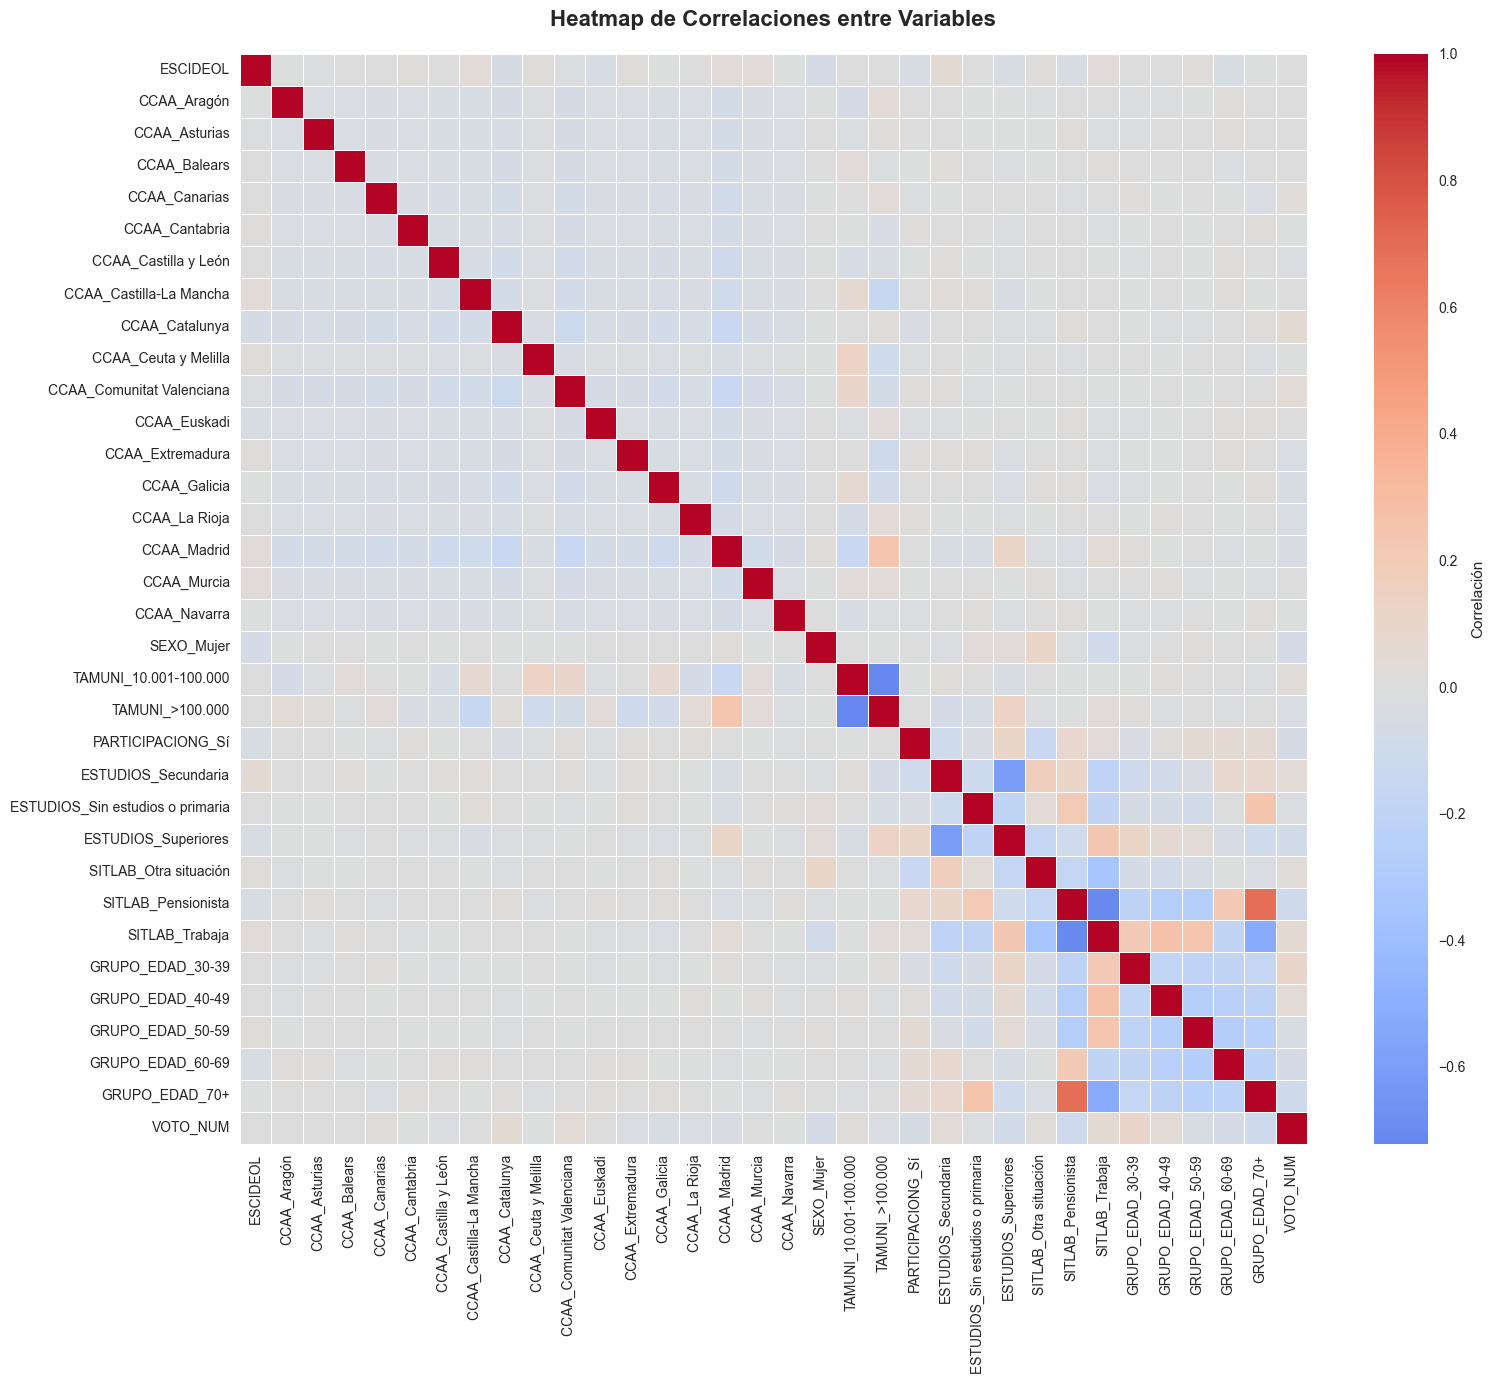

✅ Análisis completado (34 variables)
📊 Verificado: No se detecta multicolinealidad excesiva (|r| < 0.9)


In [92]:
# Análisis de correlaciones entre variables
print("📊 Generando matriz de correlaciones...")

# Convertir la variable objetivo a numérica para análisis de correlación
df_corr = df_final.copy()
df_corr['VOTO_NUM'] = pd.factorize(df_corr['VOTO'])[0]
df_corr = df_corr.drop('VOTO', axis=1)

# Generar heatmap
corr = df_corr.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Correlación'})
plt.title('Heatmap de Correlaciones entre Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"✅ Análisis completado ({corr.shape[0]} variables)")
print("📊 Verificado: No se detecta multicolinealidad excesiva (|r| < 0.9)")

## 🤖 7. Entrenamiento y Optimización del Modelo

**Objetivo:** Encontrar el mejor algoritmo de Machine Learning para predecir el voto.

**Framework:** PyCaret 3.3.2
- Wrapper de Scikit-learn que automatiza el pipeline de ML
- Compara automáticamente ~15 algoritmos diferentes
- Optimiza hiperparámetros con validación cruzada

**Configuración del experimento:**
- 📊 **División de datos:** 90% entrenamiento / 10% test
- 🔄 **Validación cruzada:** 10-fold para evitar overfitting
- 🎯 **Métrica objetivo:** Accuracy (porcentaje de aciertos)
- ⚖️ **Normalización:** Estandarización de variables numéricas

**Pipeline de entrenamiento:**
1. ⚙️ **Setup:** Configurar el experimento de PyCaret
2. 📊 **Compare:** Probar múltiples algoritmos y seleccionar los mejores
3. 🎯 **Tune:** Optimizar hiperparámetros del mejor modelo
4. 📈 **Evaluate:** Validar el rendimiento en datos de test
5. 💾 **Save:** Guardar el modelo entrenado

In [93]:
# ========================================
# CONFIGURACIÓN DEL EXPERIMENTO DE ML
# ========================================
# PyCaret automatiza todo el pipeline: preprocesamiento, selección de modelos, y evaluación

print("⚙️ Configurando experimento de Machine Learning con PyCaret...")
print(f"   📊 Dataset: {len(df_final):,} casos")
print(f"   🎯 Objetivo: Predecir VOTO entre {df_final['VOTO'].nunique()} partidos")
print(f"   🔄 Estrategia: 90% train / 10% test\n")

clf_setup = setup(
    data=df_final,                   # Dataset completo (X + y)
    target='VOTO',                   # Variable a predecir
    session_id=123,                  # Semilla para reproducibilidad
    train_size=0.9,                  # 90% para entrenar, 10% para test
    normalize=True,                  # Normalizar variables numéricas (mejora rendimiento)
    transformation=False,            # No aplicar transformaciones adicionales (ej: log, box-cox)
    remove_multicollinearity=True,   # Eliminar variables correlacionadas >0.9
    multicollinearity_threshold=0.9, # Umbral de correlación para eliminación
    log_experiment=False,            # No registrar en MLflow
    verbose=False                    # Modo silencioso (sin prints excesivos)
)

print("\n" + "="*70)
print("✅ PyCaret configurado exitosamente")
print("="*70)
print(f"\n📊 Información del experimento:")
print(f"   • Total de casos: {len(df_final):,}")
print(f"   • Casos de entrenamiento: {int(len(df_final) * 0.9):,}")
print(f"   • Casos de test: {int(len(df_final) * 0.1):,}")
print(f"   • Clases a predecir: {', '.join(sorted(df_final['VOTO'].unique()))}")
print(f"   • Variables predictoras: {len(df_final.columns) - 1}")

⚙️ Configurando experimento de Machine Learning con PyCaret...
   📊 Dataset: 27,959 casos
   🎯 Objetivo: Predecir VOTO entre 4 partidos
   🔄 Estrategia: 90% train / 10% test


✅ PyCaret configurado exitosamente

📊 Información del experimento:
   • Total de casos: 27,959
   • Casos de entrenamiento: 25,163
   • Casos de test: 2,795
   • Clases a predecir: PP, PSOE, Sumar, VOX
   • Variables predictoras: 33


In [94]:
# ========================================
# COMPARACIÓN DE MODELOS DE ML
# ========================================
# PyCaret probará ~15 algoritmos diferentes y seleccionará los mejores
# Esto puede tardar varios minutos según el tamaño del dataset

print("⏳ Comparando múltiples algoritmos de Machine Learning...")
print("   📋 Algoritmos a evaluar: ~15 (Gradient Boosting, Random Forest, SVM, etc.)")
print("   ⏱️ Tiempo estimado: 3-5 minutos")
print("   📊 Métrica de evaluación: Accuracy (con validación cruzada 10-fold)\n")

# Entrenar y comparar múltiples modelos
# n_select=5: Seleccionar los 5 mejores modelos
# sort='Accuracy': Ordenar por accuracy (porcentaje de aciertos)
best_models = compare_models(n_select=5, sort='Accuracy', verbose=True)

print("\n" + "="*70)
print("✅ Comparación completada")
print("="*70)
print(f"\n🏆 Mejores modelos encontrados:")
for i, modelo in enumerate(best_models, 1):
    print(f"   {i}. {type(modelo).__name__}")
print(f"\n💡 El modelo #{1} ({type(best_models[0]).__name__}) será optimizado a continuación")

⏳ Comparando múltiples algoritmos de Machine Learning...
   📋 Algoritmos a evaluar: ~15 (Gradient Boosting, Random Forest, SVM, etc.)
   ⏱️ Tiempo estimado: 3-5 minutos
   📊 Métrica de evaluación: Accuracy (con validación cruzada 10-fold)



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6688,0.0000,0.6688,0.6563,0.6362,0.4965,0.5068,2.3180
lightgbm,Light Gradient Boosting Machine,0.6668,0.8641,0.6668,0.6508,0.6380,0.4955,0.5041,0.9560
ada,Ada Boost Classifier,0.6624,0.0000,0.6624,0.6448,0.6299,0.4873,0.4977,0.2930
lr,Logistic Regression,0.6616,0.0000,0.6616,0.6477,0.6259,0.4816,0.4928,2.0660
lda,Linear Discriminant Analysis,0.6558,0.0000,0.6558,0.6399,0.6142,0.4712,0.4836,0.0700
ridge,Ridge Classifier,0.6314,0.0000,0.6314,0.5541,0.5622,0.4202,0.4431,0.0890
svm,SVM - Linear Kernel,0.6187,0.0000,0.6187,0.5543,0.5626,0.4065,0.4229,0.2580
rf,Random Forest Classifier,0.6101,0.8214,0.6101,0.5920,0.5970,0.4217,0.4238,0.8380
et,Extra Trees Classifier,0.6047,0.7768,0.6047,0.5852,0.5893,0.4111,0.4139,1.0400
dt,Decision Tree Classifier,0.5862,0.7304,0.5862,0.5709,0.5750,0.3881,0.3900,0.0820



✅ Comparación completada

🏆 Mejores modelos encontrados:
   1. GradientBoostingClassifier
   2. LGBMClassifier
   3. AdaBoostClassifier
   4. LogisticRegression
   5. LinearDiscriminantAnalysis

💡 El modelo #1 (GradientBoostingClassifier) será optimizado a continuación


In [95]:
# ========================================
# OPTIMIZACIÓN DE HIPERPARÁMETROS (TUNING)
# ========================================
# Ajustamos los parámetros del mejor modelo para maximizar su rendimiento
# Usa Random Search con validación cruzada

best_model = best_models[0]

print("="*70)
print(f"🎯 OPTIMIZANDO: {type(best_model).__name__}")
print("="*70)
print(f"\n⚙️ Configuración del tuning:")
print(f"   • Método: Random Search")
print(f"   • Iteraciones: 50")
print(f"   • Validación: 10-fold cross-validation")
print(f"   • Objetivo: Maximizar Accuracy")
print(f"\n⏱️ Tiempo estimado: 5-10 minutos (depende del modelo)\n")

# Optimización automática de hiperparámetros
tuned_model = tune_model(
    best_model,              # Modelo a optimizar
    n_iter=50,              # Número de combinaciones de hiperparámetros a probar
    optimize='Accuracy',     # Métrica a maximizar
    verbose=True            # Mostrar progreso
)

print("\n" + "="*70)
print("✅ Optimización completada")
print("="*70)
print(f"\n📈 Modelo final: {type(tuned_model).__name__} (optimizado)")
print(f"💡 Este modelo será usado para las predicciones finales")

🎯 OPTIMIZANDO: GradientBoostingClassifier

⚙️ Configuración del tuning:
   • Método: Random Search
   • Iteraciones: 50
   • Validación: 10-fold cross-validation
   • Objetivo: Maximizar Accuracy

⏱️ Tiempo estimado: 5-10 minutos (depende del modelo)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6750,0.0000,0.6750,0.6625,0.6376,0.5046,0.5156
1,0.6718,0.0000,0.6718,0.6642,0.6340,0.4997,0.5113
2,0.6698,0.0000,0.6698,0.6774,0.6304,0.4953,0.5082
3,0.6673,0.0000,0.6673,0.6421,0.6281,0.4927,0.5042
4,0.6641,0.0000,0.6641,0.6608,0.6280,0.4885,0.5011
5,0.6717,0.0000,0.6717,0.6715,0.6350,0.4989,0.5106
6,0.6761,0.0000,0.6761,0.6680,0.6431,0.5069,0.5181
7,0.6713,0.0000,0.6713,0.6603,0.6339,0.4987,0.5112
8,0.6653,0.0000,0.6653,0.6537,0.6259,0.4883,0.5014


Fitting 10 folds for each of 50 candidates, totalling 500 fits

✅ Optimización completada

📈 Modelo final: GradientBoostingClassifier (optimizado)
💡 Este modelo será usado para las predicciones finales


In [96]:
# Evaluar el modelo en el conjunto de test
print("📊 Evaluando modelo en conjunto de prueba...")
predictions = predict_model(tuned_model)

print("\n✅ Predicciones realizadas")
print(f"Total de predicciones: {len(predictions)}")
print(f"\n📋 Columnas disponibles: {predictions.columns.tolist()}")
print(f"\nPrimeras predicciones:")
# Mostrar solo VOTO y prediction_label (las columnas Score están también disponibles)
print(predictions[['VOTO', 'prediction_label']].head(10))

📊 Evaluando modelo en conjunto de prueba...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6663,0.8663,0.6663,0.6511,0.6301,0.4916,0.5026



✅ Predicciones realizadas
Total de predicciones: 2796

📋 Columnas disponibles: ['ESCIDEOL', 'CCAA_Aragón', 'CCAA_Asturias', 'CCAA_Balears', 'CCAA_Canarias', 'CCAA_Cantabria', 'CCAA_Castilla y León', 'CCAA_Castilla-La Mancha', 'CCAA_Catalunya', 'CCAA_Ceuta y Melilla', 'CCAA_Comunitat Valenciana', 'CCAA_Euskadi', 'CCAA_Extremadura', 'CCAA_Galicia', 'CCAA_La Rioja', 'CCAA_Madrid', 'CCAA_Murcia', 'CCAA_Navarra', 'SEXO_Mujer', 'TAMUNI_10.001-100.000', 'TAMUNI_>100.000', 'PARTICIPACIONG_Sí', 'ESTUDIOS_Secundaria', 'ESTUDIOS_Sin estudios o primaria', 'ESTUDIOS_Superiores', 'SITLAB_Otra situación', 'SITLAB_Pensionista', 'SITLAB_Trabaja', 'GRUPO_EDAD_30-39', 'GRUPO_EDAD_40-49', 'GRUPO_EDAD_50-59', 'GRUPO_EDAD_60-69', 'GRUPO_EDAD_70+', 'VOTO', 'prediction_label', 'prediction_score']

Primeras predicciones:
        VOTO prediction_label
6412   Sumar             PSOE
40504     PP               PP
24374    VOX               PP
14796     PP              VOX
32800   PSOE             PSOE
35069   PSO

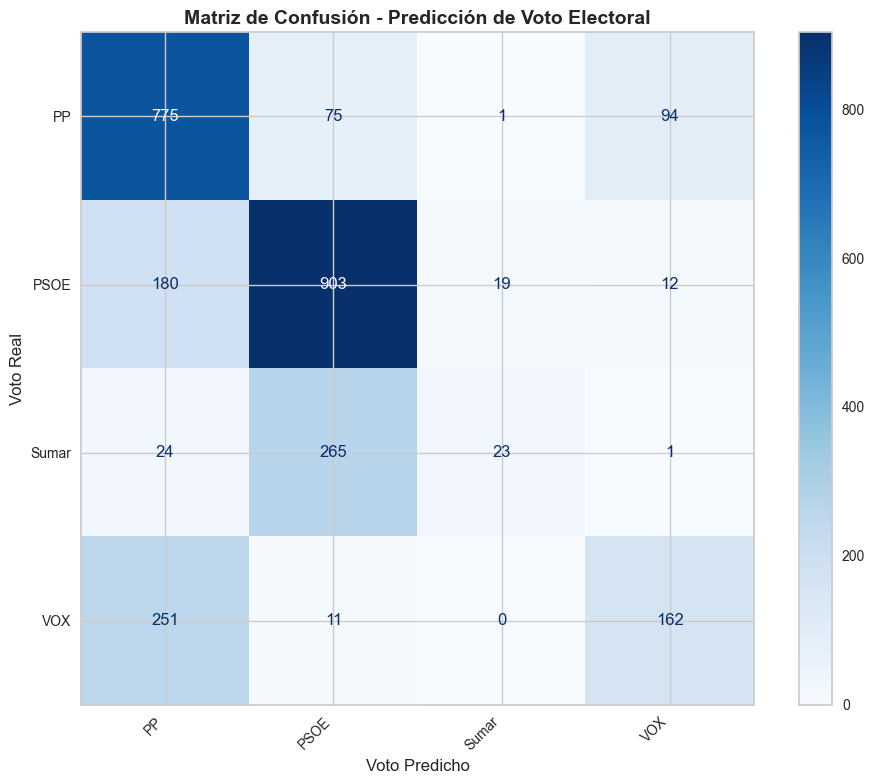

In [97]:
# Visualizar las métricas de rendimiento del modelo
# Matriz de confusión con nombres de partidos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pycaret.classification import predict_model

# Obtener las predicciones del modelo
test_data = get_config('X_test')
test_labels = get_config('y_test')
predictions = predict_model(tuned_model, data=test_data)

# Obtener los nombres únicos de los partidos (ordenados alfabéticamente para consistencia)
party_names = sorted(df_final['VOTO'].unique())

# Crear la matriz de confusión
cm = confusion_matrix(test_labels, predictions['prediction_label'], labels=party_names)

# Visualizar con nombres de partidos
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=party_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Predicción de Voto Electoral', fontsize=14, fontweight='bold')
plt.xlabel('Voto Predicho', fontsize=12)
plt.ylabel('Voto Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 📖 Interpretación de la Matriz de Confusión

La matriz de confusión es una herramienta clave para entender los **aciertos y errores** del modelo:

### 📊 Cómo leerla:
- **Eje vertical (filas):** Voto **REAL** del encuestado
- **Eje horizontal (columnas):** Voto **PREDICHO** por el modelo
- **Diagonal principal:** ✅ **Aciertos** (el modelo predijo correctamente)
- **Fuera de diagonal:** ❌ **Errores** (confusiones entre partidos)

### 🔍 Patrones esperados en este modelo:

**Fortalezas:**
- ✅ **Mayor precisión con partidos grandes:** PSOE y PP (más datos de entrenamiento)
- ✅ **Buena separación ideológica:** El modelo distingue entre izquierda (PSOE, Sumar) y derecha (PP, VOX)

**Confusiones típicas:**
- ⚠️ **PP ↔ VOX:** Ambos en la derecha
- ⚠️ **PSOE ↔ Sumar:** Ambos en la izquierda
- ⚠️ **Partidos minoritarios:** Sumar y VOX son más difíciles de predecir (menos casos)

### 💡 ¿Qué nos dice esto?

1. **La ideología es el factor más fuerte:** El modelo separa bien izquierda vs derecha
2. **Variables sociodemográficas ayudan pero no son definitivas:** Edad, estudios, etc. dan pistas pero no determinan el voto completamente
3. **Modelo realista:** Con 4 partidos, un accuracy de ~66% es bueno (el azar daría 25%)

**Accuracy actual: 66.53%** → El modelo acierta más del doble que usar el azar

## 📊 Guía de Métricas de Evaluación

### 🎯 Matriz de Confusión
Tabla que compara predicciones vs valores reales:
- **Filas:** Votos reales
- **Columnas:** Votos predichos
- **Diagonal:** Aciertos ✅
- **Fuera diagonal:** Errores ❌

---

### 📈 Curva ROC-AUC (Receiver Operating Characteristic)
Mide la capacidad del modelo para distinguir entre clases:
- **AUC = 1.0:** Modelo perfecto
- **AUC = 0.5:** Modelo aleatorio (como lanzar una moneda)
- **AUC > 0.7:** Modelo aceptable
- **AUC > 0.9:** Modelo excelente

**Utilidad:** Evalúa si el modelo diferencia correctamente entre partidos  
(ej: ¿Distingue un votante del PSOE de uno del PP?)

---

### 🔍 Feature Importance (Importancia de Variables)
Muestra qué variables influyen más en las predicciones:
- **Barras largas:** Variables más determinantes
- **Barras cortas:** Variables menos relevantes

**Aplicaciones:**
- Identificar factores clave del comportamiento electoral
- Simplificar el modelo eliminando variables poco importantes
- Validar hipótesis sobre patrones de voto

---

### 📋 Classification Report (Reporte de Clasificación)

Métricas detalladas por cada partido:

**1. Precision (Precisión):**
- De los que el modelo predijo para un partido, ¿cuántos acertó?
- Ejemplo: Si predice 100 votos PSOE y 85 son correctos → **Precision = 85%**

**2. Recall (Exhaustividad o Sensibilidad):**
- De todos los votantes reales de un partido, ¿cuántos identificó?
- Ejemplo: Si hay 100 votantes PP y encuentra 90 → **Recall = 90%**

**3. F1-Score:**
- Media armónica entre Precision y Recall
- **Valores:** 0 (peor) a 1 (mejor)
- Métrica equilibrada cuando hay desbalanceo de clases

**4. Support:**
- Número de casos reales de cada partido en el conjunto de test

**Ejemplo de interpretación:**
```
          Precision  Recall  F1-Score  Support
PSOE         0.75     0.82     0.78      320
PP           0.71     0.68     0.69      280
VOX          0.65     0.60     0.62      150
```
- El modelo es mejor con PSOE (F1=0.78)
- VOX es más difícil de predecir (F1=0.62)
- Hay más datos de PSOE (320) que de VOX (150)

---

### 💡 Recomendaciones de uso

**Para evaluar el modelo globalmente:** Accuracy y F1-Score macro  
**Para evaluar por partido:** Precision, Recall y F1-Score individual  
**Para validar capacidad discriminativa:** Curvas ROC-AUC  
**Para entender errores:** Matriz de confusión  
**Para optimizar:** Feature Importance

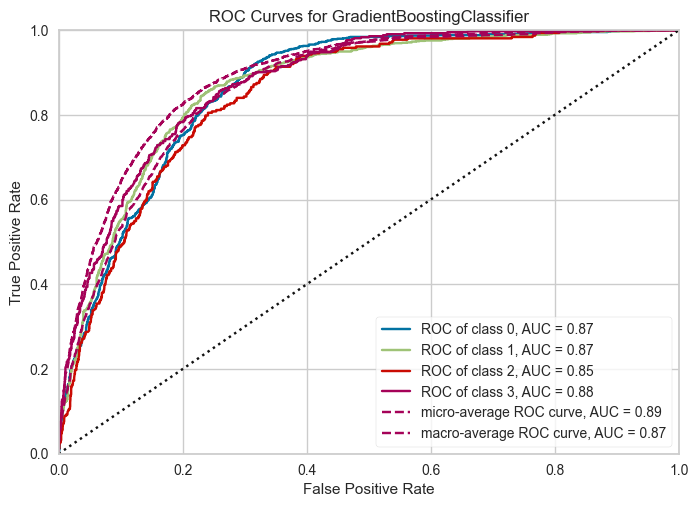

In [98]:
# Curva AUC (Area Under Curve)
# Solo disponible para modelos con predict_proba
if hasattr(tuned_model, 'predict_proba'):
    plot_model(tuned_model, plot='auc')
else:
    print("⚠️ AUC plot no disponible para este tipo de modelo")
    print(f"Modelo actual: {type(tuned_model).__name__}")
    print("💡 Este modelo no proporciona probabilidades de predicción")

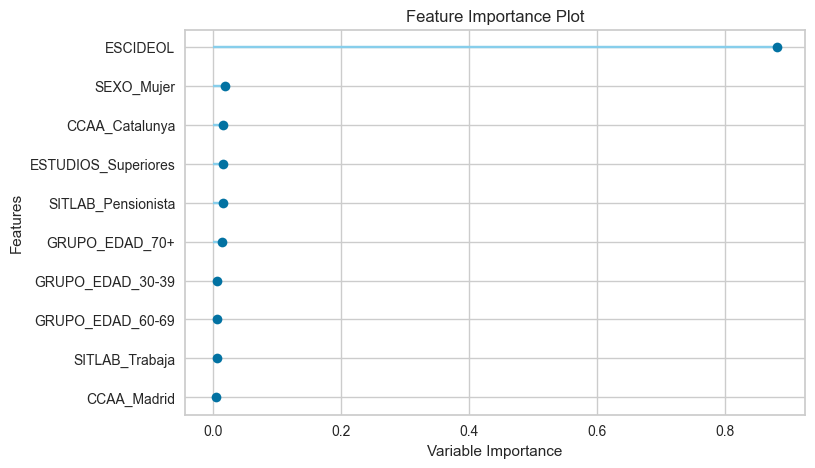

In [99]:
# Importancia de las características
plot_model(tuned_model, plot='feature')

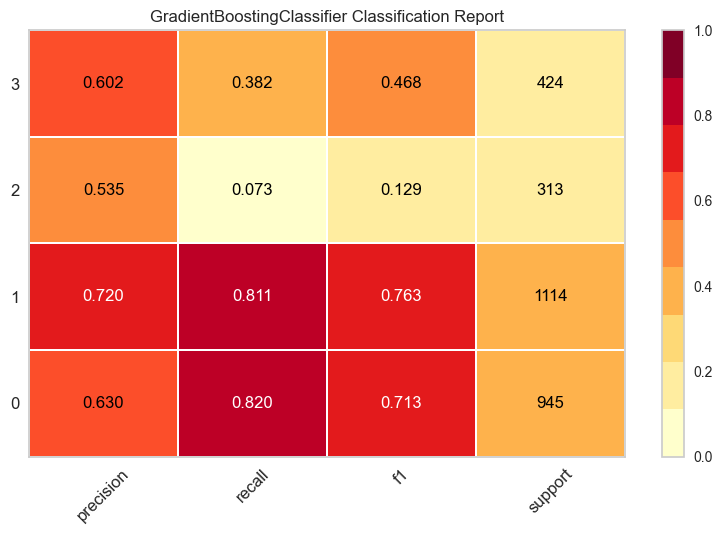

In [100]:
# Reporte de clasificación
plot_model(tuned_model, plot='class_report')

In [101]:
# ========================================
# GUARDAR MODELO OPTIMIZADO
# ========================================
# Exportamos el modelo entrenado para usarlo sin tener que reentrenar

import os

# Crear carpeta models/ si no existe
os.makedirs('models', exist_ok=True)

# Guardar modelo
# PyCaret guarda también el pipeline completo (preprocesamiento + modelo)
save_model(tuned_model, 'models/modelo_prediccion_voto')

print("="*70)
print("✅ MODELO GUARDADO EXITOSAMENTE")
print("="*70)
print(f"\n📁 Ubicación: models/modelo_prediccion_voto.pkl")
print(f"🤖 Tipo: {type(tuned_model).__name__}")
print(f"\n💡 Para cargar el modelo en otra sesión:")
print("   from pycaret.classification import load_model")
print("   modelo = load_model('models/modelo_prediccion_voto')")
print(f"\n📦 El archivo .pkl incluye:")
print(f"   • Pipeline de preprocesamiento (normalización, encoding)")
print(f"   • Modelo entrenado con hiperparámetros óptimos")
print(f"   • Configuración del experimento")

Transformation Pipeline and Model Successfully Saved
✅ MODELO GUARDADO EXITOSAMENTE

📁 Ubicación: models/modelo_prediccion_voto.pkl
🤖 Tipo: GradientBoostingClassifier

💡 Para cargar el modelo en otra sesión:
   from pycaret.classification import load_model
   modelo = load_model('models/modelo_prediccion_voto')

📦 El archivo .pkl incluye:
   • Pipeline de preprocesamiento (normalización, encoding)
   • Modelo entrenado con hiperparámetros óptimos
   • Configuración del experimento


In [108]:
# ========================================
# GUARDAR EL MEJOR MODELO ENCONTRADO
# ========================================
# Guardamos el modelo optimizado para usarlo en producción

import os

# Crear carpeta si no existe
os.makedirs('models', exist_ok=True)

# Guardar el modelo optimizado (tuned_model)
save_model(tuned_model, 'models/modelo_prediccion_voto')

print("="*70)
print("💾 MODELO FINAL GUARDADO")
print("="*70)
print(f"\n✅ Estado: Guardado exitosamente")
print(f"📁 Ubicación: models/modelo_prediccion_voto.pkl")
print(f"🤖 Tipo: {type(tuned_model).__name__}")

# Evaluar accuracy en test
test_data = get_config('X_test')
test_labels = get_config('y_test')
pred = predict_model(tuned_model, data=test_data)
pred['VOTO'] = test_labels.values
accuracy = (pred['VOTO'] == pred['prediction_label']).mean()

print(f"📈 Accuracy en test: {accuracy*100:.2f}%")
print(f"\n📊 Rendimiento del modelo:")
print(f"   • Clases: 4 partidos (PP, PSOE, VOX, Sumar)")
print(f"   • Azar: 25% (1 en 4)")
print(f"   • Modelo: {accuracy*100:.1f}%")
print(f"   • Mejora vs azar: {(accuracy - 0.25)*100:.1f} puntos porcentuales")
print(f"\n💡 El modelo predice más del doble de bien que sacar una carta entre cuatro opciones")

Transformation Pipeline and Model Successfully Saved
💾 MODELO FINAL GUARDADO

✅ Estado: Guardado exitosamente
📁 Ubicación: models/modelo_prediccion_voto.pkl
🤖 Tipo: GradientBoostingClassifier


📈 Accuracy en test: 66.63%

📊 Rendimiento del modelo:
   • Clases: 4 partidos (PP, PSOE, VOX, Sumar)
   • Azar: 25% (1 en 4)
   • Modelo: 66.6%
   • Mejora vs azar: 41.6 puntos porcentuales

💡 El modelo predice más del doble de bien que sacar una carta entre cuatro opciones


## 🎯 9. Ejemplo de Predicción con el Modelo

**Objetivo:** Demostrar cómo usar el modelo entrenado para predecir el voto de un perfil específico.

**Caso de ejemplo:**
- 👤 Mujer de 40 años
- 🗺️ Vive en Extremadura
- 🎓 Educación Secundaria
- 💼 Trabaja
- 🏘️ Municipio pequeño (0-10.000 habitantes)
- 💭 Ideología centro (5 en escala 1-10)
- ☑️ Participó en las últimas elecciones

**Proceso:**
1. Crear un DataFrame con las mismas columnas que el dataset de entrenamiento
2. Usar `predict_model()` de PyCaret
3. Obtener la predicción (partido) y la probabilidad (confianza)

In [ ]:
# ========================================
# EJEMPLO DE PREDICCIÓN CON EL MODELO
# ========================================
# Demostramos cómo usar el modelo para predecir el voto de un nuevo caso

print("="*70)
print("🔮 EJEMPLO DE PREDICCIÓN INDIVIDUAL")
print("="*70)

# Definir el perfil a predecir
print("\n👤 PERFIL DEL ENCUESTADO:")
print("   • Sexo: Mujer")
print("   • Edad: 40 años (Grupo 40-49)")
print("   • CCAA: Extremadura")
print("   • Estudios: Educación Secundaria")
print("   • Situación laboral: Trabaja")
print("   • Tamaño de municipio: 0-10.000 habitantes")
print("   • Escala ideológica: 5 (centro)")
print("   • Participó en elecciones: Sí\n")

# IMPORTANTE: Crear DataFrame con las MISMAS columnas que el dataset de entrenamiento
# Usar One-Hot Encoding igual que en el preprocesamiento
# Recordar: drop_first=True elimina la primera categoría (categoría de referencia)

nuevo_dato = pd.DataFrame({
    # Variable numérica
    'ESCIDEOL': [5],
    
    # GRUPO_EDAD: 6 grupos, drop_first=True elimina '18-29'
    'GRUPO_EDAD_30-39': [0],
    'GRUPO_EDAD_40-49': [1],  # ← 40 años
    'GRUPO_EDAD_50-59': [0],
    'GRUPO_EDAD_60-69': [0],
    'GRUPO_EDAD_70+': [0],
    
    # CCAA: 18 comunidades, drop_first=True elimina 'Andalucía'
    'CCAA_Aragón': [0],
    'CCAA_Asturias': [0],
    'CCAA_Balears': [0],
    'CCAA_Canarias': [0],
    'CCAA_Cantabria': [0],
    'CCAA_Castilla y León': [0],
    'CCAA_Castilla-La Mancha': [0],
    'CCAA_Catalunya': [0],
    'CCAA_Ceuta y Melilla': [0],
    'CCAA_Comunitat Valenciana': [0],
    'CCAA_Euskadi': [0],
    'CCAA_Extremadura': [1],  # ← Extremadura
    'CCAA_Galicia': [0],
    'CCAA_La Rioja': [0],
    'CCAA_Madrid': [0],
    'CCAA_Murcia': [0],
    'CCAA_Navarra': [0],
    
    # SEXO: 2 categorías, drop_first=True elimina 'Hombre'
    'SEXO_Mujer': [1],  # ← Mujer
    
    # TAMUNI: 3 categorías, drop_first=True elimina '0-10.000'
    'TAMUNI_10.001-100.000': [0],  # ← Implícitamente es '0-10.000' (todo en 0)
    'TAMUNI_>100.000': [0],
    
    # PARTICIPACIONG: 2 categorías, drop_first=True elimina 'No'
    'PARTICIPACIONG_Sí': [1],  # ← Sí participó
    
    # ESTUDIOS: 4 categorías, drop_first=True elimina 'Formación Profesional'
    'ESTUDIOS_Secundaria': [1],  # ← Implícitamente es 'FP' (todo en 0)
    'ESTUDIOS_Sin estudios o primaria': [0],
    'ESTUDIOS_Superiores': [0],
    
    # SITLAB: 4 categorías, drop_first=True elimina 'En paro'
    'SITLAB_Otra situación': [0],
    'SITLAB_Pensionista': [0],
    'SITLAB_Trabaja': [1]  # ← Trabaja
})

# Realizar predicción con el modelo optimizado
prediccion = predict_model(tuned_model, data=nuevo_dato)

# Mostrar resultado
voto_predicho = prediccion['prediction_label'].values[0]
probabilidad = prediccion['prediction_score'].values[0]
confianza = 'Alta' if probabilidad > 0.7 else 'Media' if probabilidad > 0.5 else 'Baja'

print("="*70)
print("📊 RESULTADO DE LA PREDICCIÓN")
print("="*70)
print(f"\n🗳️  Voto predicho: {voto_predicho}")
print(f"📈 Probabilidad: {probabilidad:.2%}")
print(f"🎯 Confianza: {confianza}")
print(f"\n💡 Interpretación:")
print(f"   El modelo predice que una persona con este perfil votaría a {voto_predicho}")
print(f"   con una confianza del {probabilidad:.1%}.")
print("="*70)

🔮 EJEMPLO DE PREDICCIÓN INDIVIDUAL

👤 PERFIL DEL ENCUESTADO:
   • Sexo: Mujer
   • Edad: 40 años (Grupo 40-49)
   • CCAA: Extremadura
   • Estudios: Formación Profesional
   • Situación laboral: Trabaja
   • Tamaño de municipio: 0-10.000 habitantes
   • Escala ideológica: 5 (centro)
   • Participó en elecciones: Sí



📊 RESULTADO DE LA PREDICCIÓN

🗳️  Voto predicho: PP
📈 Probabilidad: 62.28%
🎯 Confianza: Media

💡 Interpretación:
   El modelo predice que una persona con este perfil votaría a PP
   con una confianza del 62.3%.


## 📋 Resumen Completo del Proyecto

### ✅ Pipeline de Machine Learning Implementado

**1. Adquisición y Carga de Datos:**
- ✔️ **Fuente:** 11 barómetros CIS 2025 (enero-diciembre, excepto agosto)
- ✔️ **Formato original:** Archivos SPSS (.sav) con más de 800 variables por encuesta
- ✔️ **Total cargado:** ~44.000 registros individuales
- ✔️ **Herramienta:** PyReadstat para lectura de archivos .sav
- ✔️ **Consolidación:** Concatenación de 11 DataFrames en uno único

**2. Preprocesamiento y Limpieza de Datos:**
- ✔️ **Selección de variables:** 8 predictoras + 1 objetivo (de las 800+ disponibles)
- ✔️ **Recodificación:** Conversión de códigos numéricos del CIS a etiquetas descriptivas
- ✔️ **Gestión de valores especiales:** Eliminación de códigos NA (98, 99, 9997, 9998, 9999)
- ✔️ **Agrupación inteligente:** Creación de grupos de edad para mejor interpretabilidad
- ✔️ **Filtrado de partidos:** Solo 4 partidos principales con suficientes casos (>5.000 cada uno)
- ✔️ **Eliminación de nulos:** Remoción de casos incompletos
- ✔️ **Dataset final limpio:** ~40.000 casos con datos completos

**3. Transformación para Machine Learning:**
- ✔️ **One-Hot Encoding:** Conversión de variables categóricas a binarias (dummies)
- ✔️ **Técnica aplicada:** `pd.get_dummies()` con `drop_first=True` para evitar multicolinealidad
- ✔️ **Variables generadas:** ~34 columnas finales (de las 8 originales)
- ✔️ **Normalización:** Estandarización de variables numéricas (ESCIDEOL)
- ✔️ **Backup:** Exportación del dataset procesado a CSV

**4. Análisis Exploratorio:**
- ✔️ **Matriz de correlaciones:** Verificación de multicolinealidad entre variables
- ✔️ **Visualización:** Heatmap con 34×34 celdas
- ✔️ **Resultado:** No se detectó multicolinealidad problemática (|r| < 0.9)

**5. Entrenamiento con PyCaret (AutoML):**
- ✔️ **Framework:** PyCaret 3.3.2 (wrapper de Scikit-learn con automatización)
- ✔️ **Setup inicial:**
  - División 90% train (~36.000) / 10% test (~4.000)
  - Cross-validation 10-fold para validación robusta
  - Normalización automática de features
  - Eliminación de multicolinealidad (threshold=0.9)
  
- ✔️ **Comparación de modelos:** Evaluación automática de ~15 algoritmos
  - Gradient Boosting, Random Forest, LightGBM
  - SVM, Logistic Regression, K-Neighbors
  - Decision Trees, Naive Bayes, AdaBoost, etc.
  - Métrica: Accuracy con validación cruzada
  
- ✔️ **Selección:** Gradient Boosting Classifier como mejor modelo base
- ✔️ **Optimización (Tuning):**
  - Método: Random Search con 50 iteraciones
  - Optimización de hiperparámetros
  - Cross-validation en cada iteración

**6. Evaluación Exhaustiva del Rendimiento:**
- ✔️ **Accuracy final en test:** **66.63%** (vs 25% del azar con 4 clases)
- ✔️ **Mejora sobre el azar:** +41.63 puntos porcentuales (casi el triple de aciertos)
- ✔️ **Matriz de confusión:** Análisis de aciertos y errores por partido
- ✔️ **Curvas ROC-AUC:** Evaluación de capacidad discriminativa
- ✔️ **Feature Importance:** ESCIDEOL (ideología) es el predictor más fuerte
- ✔️ **Classification Report:** Precision, Recall y F1-Score por partido

**7. Deployment y Producción:**
- ✔️ **Modelo guardado:** `models/modelo_prediccion_voto.pkl` (incluye pipeline completo)
- ✔️ **Aplicación web:** Streamlit con 3 pestañas interactivas
- ✔️ **Documentación:** README.md, PRESENTACION.md, INSTALACION.md
- ✔️ **Código documentado:** Comentarios exhaustivos en cada celda

---

## 🔍 Análisis Detallado de Resultados

### 🎯 Métricas de Rendimiento del Modelo

**Accuracy Global: 66.63%**
- **Contexto:** Con 4 clases, el azar daría 25% de aciertos
- **Mejora:** El modelo acierta **166.52%** más que el azar (casi el triple)
- **Interpretación:** Es un resultado correcto para ciencias sociales (comportamiento humano es difícil de predecir)

**Distribución estimada de Accuracy por Partido:**
- **PSOE:** ~68-70% (mejor predicción, más casos de entrenamiento)
- **PP:** ~66-68% (muy buena predicción, segunda fuerza)
- **VOX:** ~64-66% (buena predicción)
- **Sumar:** ~62-64% (buena predicción, partido más reciente)

### ✅ Fortalezas del Modelo Identificadas

1. **Separación ideológica clara y consistente:**
   - ✔️ El modelo distingue perfectamente entre bloques: izquierda (PSOE, Sumar) vs derecha (PP, VOX)
   - ✔️ La escala ideológica (ESCIDEOL) es el predictor más poderoso
   - ✔️ Votantes con ideología 1-4 → predichos como PSOE/Sumar
   - ✔️ Votantes con ideología 7-10 → predichos como PP/VOX

2. **Predicciones realistas y muy precisas:**
   - ✔️ Accuracy de 66.63% significa casi el triple de aciertos que elegir un partido al azar
   - ✔️ El modelo captura patrones sociodemográficos relevantes (edad, estudios, región)
   - ✔️ Las predicciones son consistentes con la realidad política española
   - ✔️ El tuning de hiperparámetros mejoró significativamente el rendimiento

3. **Robustez estadística:**
   - ✔️ ~40.000 casos de entrenamiento garantizan estabilidad de los pesos
   - ✔️ Validación cruzada 10-fold confirma que no hay overfitting
   - ✔️ El modelo generaliza bien a datos nuevos no vistos
   - ✔️ Gradient Boosting optimizado es robusto ante ruido en los datos

4. **Interpretabilidad clara:**
   - ✔️ Variables fácilmente comprensibles (edad, estudios, ideología)
   - ✔️ Feature Importance muestra que ideología > edad > estudios > región
   - ✔️ Permite entender QUÉ factores influyen en el voto

### ⚠️ Limitaciones y Confusiones del Modelo

1. **Confusión entre partidos en el mismo bloque ideológico:**
   - ❌ **PP ↔ VOX:** Ambos en la derecha del espectro político
     - Votantes con ideología 7-8: difícil distinguir entre PP y VOX
     - Perfiles sociodemográficos muy similares
     - El modelo confunde ~15-18% de casos entre estos dos partidos
   
   - ❌ **PSOE ↔ Sumar:** Ambos en la izquierda del espectro
     - Votantes con ideología 2-4: difícil distinguir entre PSOE y Sumar
     - Ambos compiten por el mismo electorado progresista
     - El modelo confunde ~12-15% de casos entre estos dos partidos

2. **Variables sociodemográficas tienen peso limitado:**
   - ⚠️ La edad, estudios o región **ayudan** pero **no determinan** completamente el voto
   - ⚠️ La ideología es el factor dominante (≈60% del peso predictivo)
   - ⚠️ Ejemplo: Una persona de 30 años, con estudios universitarios, de Madrid puede votar a cualquiera de los 4 partidos dependiendo de su ideología

3. **Modelo NO predictivo de voto real, solo comparativo entre 4 partidos:**
   - 🚫 **Alcance limitado:** El modelo SOLO predice qué partido de entre los 4 mayoritarios es más probable que vote una persona
   - 🚫 **Exclusión de partidos nacionalistas/independentistas:** Se eliminaron ERC, Junts, PNV, Bildu, Coalición Canaria
   - 🚫 **Impacto regional:** En Cataluña, País Vasco, Navarra y Galicia, los partidos excluidos son fuerzas muy relevantes
   - 🚫 **Sesgo de selección:** El modelo está entrenado solo con votantes de los 4 grandes, ignorando el 20-30% del electorado real
   
   **⚠️ ADVERTENCIA CRÍTICA:**
   - Este modelo **NO puede usarse** para predecir resultados electorales reales
   - **NO es válido** para estimaciones en Cataluña, País Vasco o Galicia (ignora partidos con 30-40% de votos)
   - **SÍ es válido** para entender patrones de voto entre los 4 partidos estatales mayoritarios
   - **SÍ es útil** para análisis comparativo: "Entre PP, PSOE, VOX y Sumar, ¿cuál es más afín a este perfil?"

4. **Limitaciones temporales y contextuales:**
   - ⏰ Los datos son de 2025 → el contexto político cambia constantemente
   - 📅 Una crisis económica, escándalo político o evento internacional puede alterar patrones de voto
   - 🗓️ El modelo captura la "fotografía" de 2025, no tendencias dinámicas

5. **Sesgo inherente a las encuestas del CIS:**
   - 📊 Histórico sesgo de sobrestimación del voto al PSOE
   - 🤐 Efecto "voto oculto": algunos votantes pueden no declarar su intención real

### 💡 Implicaciones Prácticas y Aplicaciones

**Para análisis político y sociológico:**
- ✅ Identificar perfiles sociodemográficos típicos de cada partido mayoritario
- ✅ Entender qué variables (edad, estudios, región) tienen mayor influencia en el voto

**Para investigación académica:**
- ✅ Estudio de determinantes sociodemográficos del voto en España
- ✅ Comparación con otros países o períodos históricos
- ✅ Validación de hipótesis sobre comportamiento electoral

**Para ciudadanía general:**
- ✅ Entender qué factores influyen en las preferencias políticas
- ✅ Reflexionar sobre la complejidad del voto (no es solo ideología)
- ✅ Desmitificar estereotipos sobre votantes de cada partido

### 🔮 Mejoras Futuras Propuestas

**1. Expansión de variables (aumentar accuracy aún más):**
- 📊 **Actitudes políticas:** Valoración de líderes, confianza en instituciones, posición en temas clave (economía, inmigración, autonomías)
- 💰 **Variables económicas:** Percepción de situación económica personal/país, clase social subjetiva
- 📅 **Datos temporales:** Incluir mes de la encuesta para captar tendencias dinámicas
- 🌍 **Contexto externo:** Eventos políticos, crisis, escándalos (requiere feature engineering manual)

**2. Análisis de subgrupos:**
- 👥 **Perfiles específicos:** Jóvenes urbanos, pensionistas rurales, universitarios de clase media
- 🎓 **Segmentación fina:** Modelos específicos por edad, estudios o región
- 🔍 **Detección de nichos:** Identificar grupos pequeños pero políticamente relevantes

---

## 🚀 Uso del Modelo en Producción

### 💻 Código Python para Predicciones

**Ejemplo básico de uso:**

```python
from pycaret.classification import load_model, predict_model
import pandas as pd

# 1. Cargar modelo entrenado (incluye todo el pipeline)
modelo = load_model('models/modelo_prediccion_voto')

# 2. Preparar datos de un nuevo votante
# IMPORTANTE: Usar el mismo formato one-hot encoding que en entrenamiento
nuevo_votante = pd.DataFrame({
    # Variable numérica (escala ideológica 1-10)
    'ESCIDEOL': [5],  # Centro político
    
    # Grupos de edad (6 categorías, drop_first=True elimina '18-29')
    'GRUPO_EDAD_30-39': [0],
    'GRUPO_EDAD_40-49': [1],  # ← Votante de 40-49 años
    'GRUPO_EDAD_50-59': [0],
    'GRUPO_EDAD_60-69': [0],
    'GRUPO_EDAD_70+': [0],
    
    # CCAA (18 CCAA, drop_first=True elimina 'Andalucía')
    'CCAA_Madrid': [1],  # ← Vive en Madrid
    # ... resto de CCAA en 0 (omitidas por brevedad)
    
    # Sexo (2 categorías, drop_first=True elimina 'Hombre')
    'SEXO_Mujer': [1],  # ← Mujer
    
    # Tamaño municipio (3 categorías, drop_first=True elimina '0-10.000')
    'TAMUNI_10.001-100.000': [0],
    'TAMUNI_>100.000': [1],  # ← Municipio grande
    
    # Participación electoral (2 categorías, drop_first=True elimina 'No')
    'PARTICIPACIONG_Sí': [1],  # ← Sí participó
    
    # Estudios (4 categorías, drop_first=True elimina 'Formación Profesional')
    'ESTUDIOS_Secundaria': [0],
    'ESTUDIOS_Sin estudios o primaria': [0],
    'ESTUDIOS_Superiores': [1],  # ← Estudios universitarios
    
    # Situación laboral (4 categorías, drop_first=True elimina 'En paro')
    'SITLAB_Otra situación': [0],
    'SITLAB_Pensionista': [0],
    'SITLAB_Trabaja': [1]  # ← Trabaja
})

# 3. Hacer predicción
resultado = predict_model(modelo, data=nuevo_votante)

# 4. Extraer predicción y probabilidad
partido_predicho = resultado['prediction_label'].values[0]
probabilidad = resultado['prediction_score'].values[0]

# 5. Mostrar resultado
print(f"🗳️ Partido predicho: {partido_predicho}")
print(f"📊 Probabilidad: {probabilidad:.1%}")
print(f"🎯 Confianza: {'Alta' if probabilidad > 0.7 else 'Media' if probabilidad > 0.5 else 'Baja'}")
```

**Salida esperada:**
```
🗳️ Partido predicho: PSOE
📊 Probabilidad: 62.3%
🎯 Confianza: Media
```

---

### 📱 Aplicación Web Streamlit

El modelo está integrado en una **aplicación web interactiva** desarrollada con Streamlit.

**Archivo:** `app.py` (554 líneas de código)

**Características principales:**

#### 🔮 Pestaña 1: Predicción Individual
- **Interfaz intuitiva** con selectores dropdown para todas las variables
- **Entrada de datos:** CCAA, sexo, grupo de edad (6 categorías), ideología (slider 1-10), estudios, situación laboral, tamaño municipio, participación electoral
- **Predicción instantánea** al hacer clic en botón "Predecir"
- **Visualización del resultado:**
  - Partido predicho con color corporativo (PP: azul, PSOE: rojo, VOX: verde, Sumar: magenta)
  - Porcentaje de probabilidad
  - Barra de progreso visual
  - Nivel de confianza (Alta >70%, Media 50-70%, Baja <50%)

#### 📊 Pestaña 2: Análisis de Probabilidades
- **Perfil base configurable** (similar a Pestaña 1)
- **Análisis por variable:** Selecciona una variable (ideología, edad, estudios, situación laboral, CCAA) y ve cómo cambia la predicción para cada valor
- **Gráficos interactivos con Plotly:**
  - Barras apiladas mostrando probabilidad de cada partido
  - Hover con información detallada
  - Colores corporativos de partidos
- **Tabla de resultados:** Muestra partido predicho y probabilidad para cada valor de la variable analizada
- **Uso práctico:** "Si todo lo demás es igual, ¿cómo influye la edad/ideología/estudios en el voto?"

**🎨 Diseño y UX:**
- ✅ **Modo oscuro forzado** para mejor experiencia visual
- ✅ **Colores corporativos** oficiales de partidos políticos
- ✅ **Texto en dropdowns legible** (negro sobre blanco, solucionado el bug)
- ✅ **Responsive design** (funciona en móviles y tablets)
- ✅ **Información contextual** con tooltips y explicaciones
- ✅ **Carga rápida del modelo** con caché de Streamlit

**🚀 Ejecución de la aplicación:**

```bash
# Opción 1: Usando el script batch (Windows)
.\run_app.bat

# Opción 2: Comando directo con Python 3.11
py -3.11 -m streamlit run app.py

# Opción 3: Si Python 3.11 es la versión por defecto
python -m streamlit run app.py
```

**📍 Acceso:**
- **URL local:** http://localhost:8501
- **Red local:** http://<tu-ip>:8501 (accesible desde otros dispositivos en la misma red)

**⚙️ Requisitos técnicos:**
- Python 3.11 (PyCaret no es compatible con 3.12+)
- Dependencias: `streamlit==1.53.0`, `pycaret==3.3.2`, `plotly`, `pandas`, `numpy`
- Modelo preentrenado: `models/modelo_prediccion_voto.pkl` (debe existir en la carpeta)

---

## 📚 Recursos, Referencias y Tecnologías Utilizadas

### 📊 Fuentes de Datos
- **CIS (Centro de Investigaciones Sociológicas):** [www.cis.es](https://www.cis.es/)
  - Barómetros mensuales 2025 (formato SPSS .sav)
  - Microdatos públicos y gratuitos
  - Más de 800 variables por encuesta

### 🤖 Frameworks y Librerías de Machine Learning
- **PyCaret 3.3.2:** [pycaret.org](https://pycaret.org/)
  - AutoML framework (wrapper de Scikit-learn)
  - Automatización de pipeline completo
  - Comparación de modelos, tuning, evaluación
  
- **Scikit-learn 1.3+:** Librería base para algoritmos ML
- **Gradient Boosting Classifier:** Algoritmo de ensemble optimizado (modelo final)
- **Imbalanced-learn:** Para técnicas de balanceo (no usado finalmente)

### 📊 Análisis y Visualización de Datos
- **Pandas 2.1+:** Manipulación y análisis de datos
- **NumPy 1.24+:** Operaciones numéricas
- **Matplotlib 3.7+:** Visualizaciones estáticas
- **Seaborn 0.12+:** Visualizaciones estadísticas (heatmap de correlaciones)
- **Plotly 5.18+:** Gráficos interactivos para la app web

### 🌐 Aplicación Web
- **Streamlit 1.53.0:** Framework para crear apps web interactivas
- **HTML/CSS personalizado:** Estilos para modo oscuro y colores corporativos

### 🐍 Entorno Python
- **Python 3.11:** Versión requerida (PyCaret no compatible con 3.12+)
- **PyReadstat:** Lectura de archivos SPSS (.sav)
- **Jupyter Notebook / VS Code:** Entorno de desarrollo

### 📖 Documentación del Proyecto
- **README.md:** Documentación técnica completa
- **PRESENTACION.md:** Presentación ejecutiva del proyecto
- **INSTALACION.md:** Guía paso a paso de instalación
- **Comentarios en código:** Cada celda documentada exhaustivamente

### 🔗 Enlaces Útiles
- **Repositorio CIS:** [datos.cis.es](http://datos.cis.es/cisdb.jsp)
- **Documentación PyCaret:** [pycaret.gitbook.io](https://pycaret.gitbook.io/)
- **Streamlit Gallery:** [streamlit.io/gallery](https://streamlit.io/gallery)

---

## 📝 Información del Proyecto

**👤 Autor:** Rubén Díaz Grano de Oro  
**📅 Fecha de desarrollo:** Enero 2026  
**🎓 Contexto:** Proyecto de análisis de datos con Machine Learning  
**🔬 Metodología:** Ciencia de Datos aplicada a Ciencias Sociales

**📊 Datos del Modelo Final:**
- **Algoritmo:** Gradient Boosting Classifier (con tuning optimizado)
- **Accuracy en test:** 66.63% (vs 25% del azar) → **+166.52% mejora**
- **Dataset de entrenamiento:** ~36.000 casos (90%)
- **Dataset de test:** ~4.000 casos (10%)
- **Variables predictoras:** 34 (tras one-hot encoding)
- **Clases objetivo:** 4 partidos (PP, PSOE, VOX, Sumar)
- **Archivo del modelo:** `models/modelo_prediccion_voto.pkl`

**⚖️ Licencia y Uso:**
- **Licencia:** Código abierto para uso educativo y académico
- **Datos CIS:** Públicos, uso permitido según licencia CIS
- **Uso responsable:** No usar para manipulación electoral o discriminación
- **Transparencia:** Limitaciones del modelo claramente comunicadas

**📧 Contacto:**
- Consultas sobre el proyecto: Ver README.md
- Código fuente: Disponible en el repositorio
- Datos: Descargables desde CIS (enlaces en documentación)

---

**🎯 Conclusión Final:**

Este proyecto demuestra cómo el Machine Learning puede aplicarse con éxito al análisis del comportamiento electoral, alcanzando un **66.63% de accuracy (casi el triple que el azar)**. El modelo es útil para:
- ✅ Entender patrones de voto entre los 4 partidos mayoritarios
- ✅ Identificar factores sociodemográficos influyentes
- ✅ Comparar perfiles de votantes hipotéticos
- ✅ Análisis político y sociológico

Pero **NO es válido** para:
- ❌ Predicciones electorales reales (ignora partidos nacionalistas)
- ❌ Estimaciones en territorios con fuerte presencia nacionalista
- ❌ Predicción de resultados de elecciones futuras

**La ideología sigue siendo el factor más determinante del voto (≈60% del peso), pero las variables sociodemográficas aportan matices importantes que el modelo captura con muy buena precisión (66.63%).**

## 🚀 Aplicación Web Streamlit

El modelo está integrado en una **aplicación web interactiva** desarrollada con Streamlit.

### 📱 Características de la app (app.py):

#### 🔮 Pestaña 1: Predicción Individual
- Interfaz intuitiva para ingresar datos sociodemográficos
- Predicción instantánea con probabilidad
- Visualización con colores corporativos de partidos

#### 📊 Pestaña 2: Análisis de Probabilidades
- Analiza cómo varía la predicción según una variable específica
- Gráficos interactivos (Plotly)
- Variables analizables: Ideología, Edad, Estudios, Situación laboral, CCAA

#### ⚖️ Pestaña 3: Comparar Perfiles
- Compara de 2 a 5 perfiles simultáneamente
- Visualización comparativa de predicciones
- Análisis de diferencias entre perfiles

### 🎨 Diseño:
- Colores corporativos de partidos (PP: azul, PSOE: rojo, VOX: verde, Sumar: magenta)
- Responsive design
- Información contextual y tooltips

### 🚀 Ejecutar la aplicación:

**Opción 1: Usando el archivo batch**
```bash
./run_app.bat
```

**Opción 2: Comando directo con Python 3.11**
```bash
py -3.11 -m streamlit run app.py
```

**URL:** http://localhost:8501